In [93]:
# Importing modules

# Data loading and test/train split
from bs4 import BeautifulSoup
from skimage import io
import os
import sys
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt

# VBOW
from scipy.cluster.vq import kmeans, vq
import numpy as np

# HOG
from skimage.feature import hog
from skimage import exposure

# MPEG 
import cv2
from src.train import train
from src.evaluate import evaluate
from src.query import query
from src.descriptors.descriptor import Descriptor
from src.descriptors.dominant_color import DominantColorDescriptor
from src.descriptors.color_layout import ColorLayoutDescriptor
from src.descriptors.color_structure import ColorStructureDescriptor

# Importing the data 

Link to the Pascal challenge: \
http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html


As per Sayantan's pdf, we are only going to be doing this part of the challenge:\
Classification: For each of the twenty classes, predicting presence/absence of an example of that class in the test image.

In other words, no bounding boxes for individual features. We could optionally do that later but maybe now we can dispense with it, our task is to idenfity object classes and classify each image as containing a given class (out of 20).

##  Load and divide the data into train and test set
- We loop through all annotation xml files
- We load those files in the `getData()` function using BeautifulSoup
- Then we get all the given lables for that image
    - Each XML file contains an object tags for each object in the image within which we can find a name tag wich holds the label
    - We then search for the name tag, strip the opening and closing tag and are left with the label itself
- We do the same to extract the filename of the image and join it with the image path
- We load the image itself using skimage
    - This loads the file as an ndarray consisting of arrays holding the RGB values for each pixel
- In the end we use sklearns `train_test_split()` method to split the data accordingly

In [37]:
# Extra Block for the error AttributeError: 'str' object has no attribute 'removeprefix'. Please overlook! 
def removeprefix(self: str, prefix: str, /) -> str:
    if self.startswith(prefix):
        return self[len(prefix):]
    else:
        return self[:]

def removesuffix(self: str, suffix: str, /) -> str:
    # suffix='' should not call self[:-0].
    if suffix and self.endswith(suffix):
        return self[:-len(suffix)]
    else:
        return self[:]

In [38]:
# Extra Block for the error AttributeError: 'str' object has no attribute 'removeprefix'. Please overlook! 
#Classes: person, bird, cat, cow, dog, horse, sheep, aeroplane, bicycle, boat, bus, car, motorbike, train, bottle, chair, dining table, potted plant, sofa, tv/monitor

jpegPath = './Data_train/JPEGImages'
annotationPath = "./Data_train/Annotations"
images = []
labels = []
x_train = x_test = y_train = y_test = None

def getData(path: str) -> None:
    """Takes the path to a annotation xml file and appends the lables and the image to the global list.
    
        Parameters:
            path: str

        Returns:
            None
    """
    tempLabels = []
    with open(path, 'r') as f:
        data = f.read()
        bs_data = BeautifulSoup(data, "xml")

        #GET IMAGE LABELS
        foundLables = bs_data.find_all('object') #This holds the labels for the image
        for label in foundLables:
            labelWithTags = str(label.find('name'))
            tempLabels.append(removesuffix(removeprefix(labelWithTags,'<name>'),'</name>'))

        #GET IMAGES
        foundFilenames = bs_data.find('filename') #This holds the filename of the image
        imagePath = os.path.join(jpegPath, removesuffix(removeprefix(str(foundFilenames),'<filename>'),'</filename>'))
        images.append(io.imread(imagePath)) #Load image from specified path (ndarray of color values)
        f.close()
    labels.append(tempLabels)          

def getTestTrainingData():
    """Goes through the specified annotations directory and splits the found data 50/50 into a training and test set.
    
        Parameters: None

        Returns: None
    """
    for annoXML in os.listdir(annotationPath):
        path = os.path.join(annotationPath, annoXML)
        getData(path)
    
    global x_train, x_test, y_train, y_test
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.5)

getTestTrainingData()
print("Train test split succeded\nTrain size: "+ str(len(x_train))+"\nTest Size: "+str(len(x_test)))

Train test split succeded
Train size: 2505
Test Size: 2506


In [39]:
#Classes: person, bird, cat, cow, dog, horse, sheep, aeroplane, bicycle, boat, bus, car, motorbike, train, bottle, chair, dining table, potted plant, sofa, tv/monitor

jpegPath = './Data_train/JPEGImages'
annotationPath = "./Data_train/Annotations"
images = []
labels = []
x_train = x_test = y_train = y_test = None

def getData(path: str) -> None:
    """Takes the path to a annotation xml file and appends the lables and the image to the global list.
    
        Parameters:
            path: str

        Returns:
            None
    """
    tempLabels = []
    with open(path, 'r') as f:
        data = f.read()
        bs_data = BeautifulSoup(data, "xml")

        #GET IMAGE LABELS
        foundLables = bs_data.find_all('object') #This holds the labels for the image
        for label in foundLables:
            labelWithTags = str(label.find('name'))
            tempLabels.append(labelWithTags.removeprefix('<name>').removesuffix('</name>'))

        #GET IMAGES
        foundFilenames = bs_data.find('filename') #This holds the filename of the image
        imagePath = os.path.join(jpegPath, str(foundFilenames).removeprefix('<filename>').removesuffix('</filename>'))
        images.append(io.imread(imagePath)) #Load image from specified path (ndarray of color values)
        f.close()
    labels.append(tempLabels)          

def getTestTrainingData():
    """Goes through the specified annotations directory and splits the found data 50/50 into a training and test set.
    
        Parameters: None

        Returns: None
    """
    for annoXML in os.listdir(annotationPath):
        path = os.path.join(annotationPath, annoXML)
        getData(path)
    
    global x_train, x_test, y_train, y_test
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.5)

getTestTrainingData()
print("Train test split succeded\nTrain size: "+ str(len(x_train))+"\nTest Size: "+str(len(x_test)))

Train test split succeded
Train size: 2505
Test Size: 2506


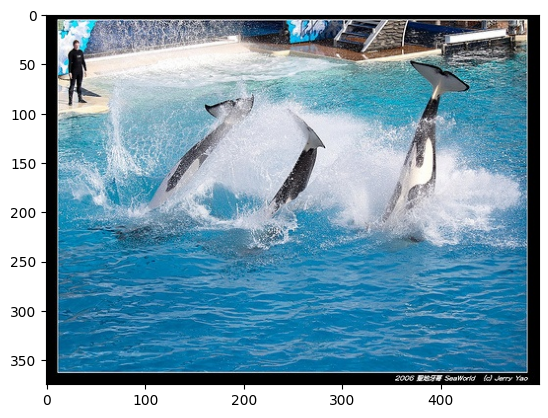

In [40]:
plt.imshow(x_train[0])

In [49]:
tfidf = bovw(x_train[:500], 50, 250)


keypoints and descriptors extracted
All feature vectors gathered. Now: building codebook
codebook finished
vectors quantization done, now: creating sparse frequency vectors
finished bovw


In [11]:
print(len(tfidf))
print(len(tfidf[0]))

500
50


In [73]:
tfidf

array([[ 9.,  5.,  7., ...,  3., 51.,  8.],
       [ 9.,  0.,  9., ...,  2., 10.,  6.],
       [ 1.,  1.,  9., ...,  6.,  3., 11.],
       ...,
       [19.,  9., 17., ..., 18., 29., 26.],
       [11.,  2., 10., ...,  4., 11., 11.],
       [ 4.,  3.,  2., ...,  2.,  1.,  3.]])

In [95]:
hogfd = HOG_extractor(x_train[:500])
hogfd

array([[0.57524289, 0.22549645, 0.13210825, ..., 0.43214094, 0.41528711,
        0.0792671 ],
       [0.76871061, 0.28265591, 0.33551576, ..., 0.0687159 , 0.01848513,
        0.02313429],
       [0.59057171, 0.09732053, 0.00740342, ..., 0.21912147, 0.37398587,
        0.28870373],
       ...,
       [0.62240469, 0.11042427, 0.40585363, ..., 0.28530902, 0.46233035,
        0.24801065],
       [0.58528243, 0.40039934, 0.32257705, ..., 0.02901719, 0.04000636,
        0.08059925],
       [0.4442495 , 0.01832651, 0.0229931 , ..., 0.28237159, 0.50199754,
        0.34856058]])

# Feature selection / vectorising the data

Reference features provided in the task document are as follows:

1. MPEG-7 Color Layout Descriptor \
 https://en.wikipedia.org/wiki/Color_layout_descriptor
2. Visual Bag-of-Words \
https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision
3. Speeded up robust features (SURF) \
 https://en.wikipedia.org/wiki/Speeded_up_robust_features

Again we could experiment with using different ones. We have to make sure we do feature extraction on a portion of the data, rather than the whole data, for CV, as Sayantan said this would be cheating 


This is super important, one of the tasks being "Extract meaningful hand-crafted features \[...] using appropriate libraries or implement them from scratch. Reference to some hand-crafted features are provided. Identify and extract at least one extra feature of your choice other than the three features mentioned in the task. Why did you select this these feature(s) out of other options?
"

## HOG

Histogram of Oriented Gradients, aka HOG, is the one extra feature extraction method not mentioned in the task assignment. 

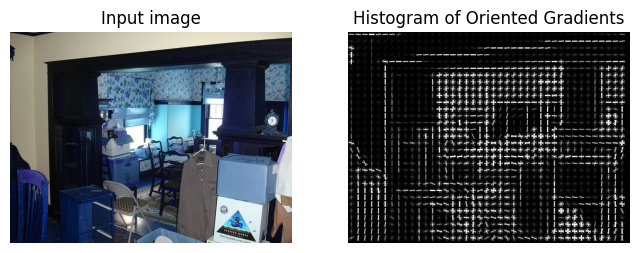

In [91]:
# The following dummy code is for visualisation purposes only for an easy understanding of what HOG performs 

# Load a sample image
image = cv.imread("./Data_train/JPEGImages/000005.jpg")

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(12, 12),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [94]:
def HOG_extractor(data: list, block_norm: str = 'L2') -> np.ndarray:

    """
    A wrapper for extracting features using the Histogram of Oriented Gradients method.
    All images are resised to the same dimensions and blurred with a Gaussian filter. 
    Optionally specify different normalisation, the default is L2. 
    """

    # Initialise an empty list of features
    hog_features = []

    # Iterate over the images 
    for img in data:

        # Resize the images
        image = cv.resize(img, (150, 200), interpolation = cv.INTER_LINEAR)

        # Apply Gaussian filter
        blur = cv.GaussianBlur(image, (5, 5), 0)

        # Extract the features using HOG
        fd = hog(
        image,
        orientations=8,
        pixels_per_cell=(12, 12),
        cells_per_block=(1, 1),
        channel_axis=-1, # Specify the colour channel as the last column
        block_norm = block_norm) 

        hog_features.append(fd)
        
    return np.array(hog_features)

## Visual Bag of Words

BoVW is a method used for building image emeddings.

1. Extract visual features -> SIFT
    - consist of keypoints: points that do not change if image is rotated, expanded or scaled
    - And descriptors: vector representations of an image patch found at a given keypoint
2. Create codebook with all existing visual words -> k-means
3. Build sparse frequency vectors with these visual words

In [48]:
# hyperparam iterations = 1?
# param data: list of images on which to apply bovw
# param n_words: how large should the codebook be?
# param n_samples: how many samples to build the codebook?
def bovw(data, n_words, n_samples, iterations=1):
    # extractor SIFT to get the visual features
    extractor = cv.SIFT_create()

    # lists to store all keypoints and descriptors
    keypoints = []
    descriptors = []

    for img in data:
        img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
        keypoints.append(img_keypoints)
        descriptors.append(img_descriptors)

    print("keypoints and descriptors extracted")

    # get sample of descriptors
    # select n_samples random image index values
    sample_idx = np.random.randint(0, len(data), n_samples).tolist()

    # extract the sample from descriptors
    # (we don't need keypoints)
    descriptors_sample = []

    for n in sample_idx:
        descriptors_sample.append(np.array(descriptors[n]))

    all_descriptors = []
    # convert all discriptors into a single array (some images may have more than others)
    for img_descriptors in descriptors_sample:
        # extract specific descriptors within the image
        for descriptor in img_descriptors:
            all_descriptors.append(descriptor)
    
    # convert to single numpy array (contains all feature vectors)
    all_descriptors = np.stack(all_descriptors)

    print("All feature vectors gathered. Now: building codebook")

    # perform k-means clustering to build the codebook
    k = n_words
    codebook, variance = kmeans(all_descriptors, k_or_guess=n_words, iter=iterations)

    print("codebook finished")

    # vector quantization
    visual_words = []
    for img_descriptors in descriptors:
        # for each image map each descriptor to the nearest codebook entry
        img_visual_words, distance = vq(img_descriptors, codebook)
        visual_words.append(img_visual_words)

    print("vectors quantization done, now: creating sparse frequency vectors")
    # creating sparse frequency_vectors 
    frequency_vectors = []
    for img_visual_words in visual_words:
        # create frequency vector for each image
        img_frequency_vector = np.zeros(k)
        for word in img_visual_words:
            img_frequency_vector[word] += 1
        frequency_vectors.append(img_frequency_vector)       
    # stack together in numpy array
    frequency_vectors = np.stack(frequency_vectors)

    print("finished bovw")

    # Tf-idf
    #N = len(data)
    #df = np.sum(frequency_vectors > 0, axis=0)
    #idf = np.log(N/df)

    #tfidf = frequency_vectors *idf

    return frequency_vectors



# MPEG-7

MPEG-7 is a multimedia content description standard.The following descriptor methods can be used. 
- Color Layout Descriptor (CLD): Captures the spatial distribution of colors in an image. It divides the image into a grid and computes color moments for each grid cell.The feature extraction process consists of two parts: grid based representative color selection and discrete cosine transform with quantization.[It is a reference feature in the task document.]

- Dominant Color Descriptor (DCD): Captures the dominant colors in an image. It quantizes the color space and computes the frequency of each color cluster.

- Color Structure Descriptor (CSD): Describes the spatial arrangement of color structures in an image. It analyzes the distribution of color pairs in predefined directions.

In [26]:
"""
The toolkit originally comes from https://github.com/lucas-gtr/MPEG7_Descriptors with 
adaption for the project. It includes three functions: training, evaluation and querying
the descriptors. 
"""

def train(train_image_list: list, descriptor_used: Descriptor, output_file: str):
    """
    Uses selected descriptor on a set of images and saves the results to a file.

    Args:
        train_image_list(list): A list containing training images.
        descriptor_used (str): Descriptor to use.
        output_file (str): Path to the output file.
    """
    n_images = len(train_image_list)
    print(f"training {n_images} images")
    with open(output_file, 'w') as f:
        for idx, img in enumerate(train_image_list):
            descriptor = descriptor_used.get_descriptor(img)
            f.write(f"{idx} {descriptor}\n")

            # Clear the line for progression
            print('\033[1A', end='\x1b[2K')
            print('\033[1A', end='\x1b[2K')

    print(f"\n{descriptor_used.name} descriptor was used. "
          f"Results were saved in '{output_file}'.")


def evaluate(test_image_list: list,y_true: list, descriptor_used: Descriptor, descriptor_database: str):
    """
    Evaluates the performance of a descriptor on a test dataset.

    Args:
        test_image_list (list): A list containing test images.
        y_true(list): A list containing the original labels. 
        descriptor_used (Descriptor): Descriptor to use.
        descriptor_database (str): Path to the descriptor database file.
    """
    y_pred = []

    n_images = len(test_image_list)
    print(f"evaluating {n_images} images")
    for idx, query_img in enumerate(test_image_list):
        distances_list = descriptor_used.get_prediction(query_img, descriptor_database)
        pred_labels = [distances[0].split("/")[-2] for distances in distances_list]
        y_pred.append(pred_labels)

        # Clear the line for progression
        print('\033[1A', end='\x1b[2K')
        print('\033[1A', end='\x1b[2K')

    print(f"The accuracy of the {descriptor_used.name}is {calculate_mean_average_precision(y_pred, y_true) * 100:.2f}%")


def calculate_mean_average_precision(batch_pred: list, batch_true: list):
    """
    Calculates the mean average precision (mAP) for a set of predictions.

    Args:
        batch_pred (list): Predicted labels for each query image.
        batch_true (list): True labels for each query image.

    Returns:
        float: Mean average precision.
    """
    total_map = 0
    num_batches = len(batch_true)
    for batch_idx in range(num_batches):
        y_true = batch_true[batch_idx]
        y_pred = batch_pred[batch_idx]
        num_correct = 0
        total_precision = 0
        for i in range(5):
            if y_pred[i] == y_true:
                num_correct += 1
                precision = num_correct / (i + 1)
                total_precision += precision
        if num_correct == 0:
            avg_precision = 0
        else:
            avg_precision = total_precision / num_correct

        total_map += avg_precision
    return total_map / num_batches
    
def query(query_img_list: list, descriptor_used: Descriptor, descriptor_database: str):
    """
    Displays matching images for a query image.

    Args:
        query_img_list (list): A list containing the query images.
        descriptor_used (Descriptor): Descriptor to use.
        descriptor_database (str): Path to the descriptor database file.
    """
    for query_img in query_img_list: 
        distances_list = descriptor_used.get_prediction(query_img, descriptor_database)
        pred_labels = [distances[0].split("/")[-2] for distances in distances_list]
        fig = plt.figure(figsize=(15, 7))
        add_image_to_plot(fig, 1, query_img, "Query image")

        for i in range(5):
            match_image = cv2.imread(distances_list[i][0])
            add_image_to_plot(fig, i + 2, match_image, f"Match {i + 1}", pred_labels[i])

        plt.show()
        plt.close(fig)


def add_image_to_plot(fig, n: int, img, title: str, label: str = None):
    """
    Adds an image to a plot.

    Args:
        fig (matplotlib.figure.Figure): Figure object.
        n (int): Position index for the subplot.
        img (numpy.ndarray): Image array.
        title (str): Title for the subplot.
        label (str, optional): Label for the image. Defaults to None.
    """
    ax = fig.add_subplot(2, 3, n)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    if label:
        plt.text(0.5, -0.03, label,
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax.transAxes, color='black', fontsize=8)

In [27]:
"""
1. Three modes to be chosen:
Train: train(train_image_list: list, descriptor_used: Descriptor, output_file: str)
Evaluate: evaluate(test_image_list: list,y_true: list, descriptor_used: Descriptor, descriptor_database: str)
Query: query(query_img_list: list, descriptor_used: Descriptor, descriptor_database: str)

2. x_image_list is the list containing image, 
   output_file and descriptor_database are paths, 
   descriptor_used can be chosen from: 
     1) DCD: DominantColorDescriptor(Td, alpha),
     2) CLD: ColorLayoutDescriptor(y_coeff_number, c_coeff_number, w_y, w_cr, w_cb),
     3) CSD: ColorStructureDescriptor(n_quantization) 
    Variables are temporaily fixed belows. 
"""

# Variables for Dominant Color Descriptor
Td = 20  # For distance calculation (usually between 10 and 20)
alpha = 1.5  # For distance calculation (usually between 1.0 and 1.5)

# Variables for Color Layout Descriptor
y_coeff_number = 6  # For descriptor size
c_coeff_number = 3  # For descriptor size (usually there are more Y coeff number than Cr, Cb)
# Weights for distance calculation
w_y = 1
w_cr = 1
w_cb = 1

# Variables for Color Structure Descriptor
n_quantization = 64  # For descriptor size
assert n_quantization in {32, 64, 128, 256}, "The value of n_quantization must be 32, 64, 128, or 256."

In [30]:
# The actual execution part

directory_name = "MPEG"
if not os.path.exists(directory_name):
        os.makedirs(directory_name)
train_file = 'CSD_train.txt'
output_file = os.path.join(directory_name,train_file)    

# For training
train_image_list = x_train[:500]
descriptor_used = ColorStructureDescriptor(n_quantization) 
train(train_image_list, descriptor_used, output_file)

# ---------------------Haven't finshed 
# # For evaluating
# test_image_list =  x_train[500:600]
# y_true = y_train[500:600]
# descriptor_used = ColorLayoutDescriptor(y_coeff_number, c_coeff_number, w_y, w_cr, w_cb)
# descriptor_database = output_file
# evaluate(test_image_list, y_true, descriptor_used, descriptor_database)

# # For querying
# query_img_list = x_train[600:700]
# descriptor_used = ColorLayoutDescriptor(y_coeff_number, c_coeff_number, w_y, w_cr, w_cb)
# descriptor_database = output_file
# query(query_img_list, descriptor_used, descriptor_database)


training 500 images

CSD descriptor was used. Results were saved in 'MPEG\CSD_train.txt'.


# Algorithm selection

I'm guessing we could get away with just picking one. I suggest constrained clustering, COP-k-Means. We could even experiment with running two separate algs and compare, like got with PCK-Means and compare the performance to COP-k-Means, they're quite similar

Here is the link to the lecture slides about these algorithms.\
https://elearning.ovgu.de/pluginfile.php/937020/mod_resource/content/2/english_ATiML05_ConstrainedClustering.pdf

Constrained clustering incorporates domain knowledge into the clustering process. In our case, domain knowledge would be super wide, essentially which features should be present for which object class. Domain knowledge that we can introduce includes 
1. Number of clusters (it's 20, Pascal tells us) 
2. Minimum cluster variance (not sure)
3. Min / Max cluster size
4. Must-link constraints
5. Cannot-link constraints

COP-k-Means is a modified k-means clustering algorithm that allows for constraints. It modifies step 1 of the k-means process (initialising cluster centres) by disallowing assignment to a cluster if the must constraint is already satisfied with another cluster or if the cannot-link constraint applies. 

The paper that describes the algorithm is here:
https://web.cse.msu.edu/~cse802/notes/ConstrainedKmeans.pdf \
It's also where the slides got their low quality screenshot of algorithm steps from

# Model selection

CV and the like, gotta plot that error as a function of lambda / M for Sayantan for sure

# Generalisation error / testing

50 % of the Pascal dataset is set to be for testing